In [5]:
import pandas as pd
import numpy as np
import nltk
import re
import string
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pyexpat import model
import pandas as pd
from scripts.util import  join_text, clean_text,tokenize, calculate_word_freq
from sklearn.model_selection import train_test_split
from scripts.nlp_func import build_w2v_model, build_model, build_d2v_model, evaluate_model, plot_confusion_matrix
import gensim
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

## load the dataset, remove the unwanted columns

In [6]:
df=pd.read_csv('data/spam.csv',header=0, encoding="ISO-8859-1",usecols=[0,1], names=['label', 'text'])
print(f"Shape of the dataset: {df.shape}")
print(f"samples of the dataset: {df.head()}")

Shape of the dataset: (5572, 2)
samples of the dataset:   label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


# Explore the data

### how many spam and ham messages are there?

In [7]:
counts=df.label.value_counts()
ham_ratio=round(counts[0]/counts.sum(),2)
spam_ratio=round(counts[1]/counts.sum(),2)
print(counts)
print(f"This is imbalanced data. The ratio of ham to spam is {ham_ratio}:{spam_ratio}")


ham     4825
spam     747
Name: label, dtype: int64
This is imbalanced data. The ratio of ham to spam is 0.87:0.13


## claculate the words' frequency in spam and ham messages

### most common words in spam messages

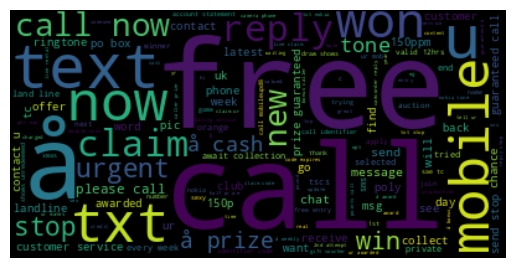

In [8]:
spam_text= "".join([word.lower() for word in join_text(df[df.label=='spam'].text) if word not in string.punctuation])
wordcloud=WordCloud().generate(spam_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'Top 25 Spam Words')

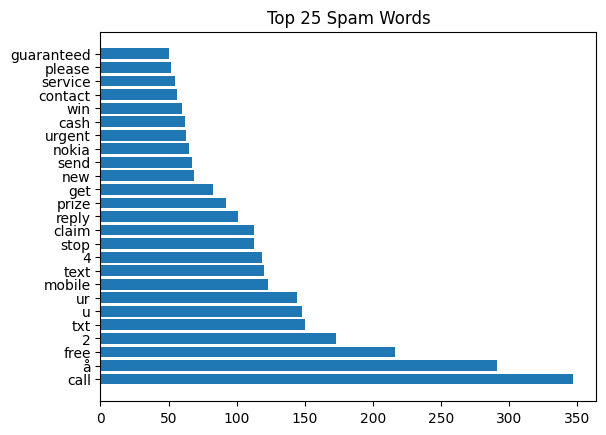

In [9]:
sort_spam_word=calculate_word_freq(spam_text,clean_text)
top_N=25
plt.barh(sort_spam_word['Word'][:top_N], sort_spam_word['Frequency'][:top_N])
plt.title(f"Top {top_N} Spam Words")

### most common words in ham messages

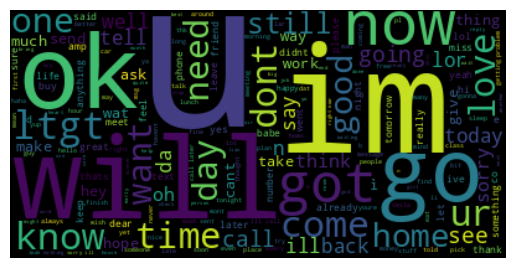

In [10]:
ham_text= "".join([word.lower() for word in join_text(df[df.label=='ham'].text) if word not in string.punctuation])
wordcloud=WordCloud().generate(ham_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'Top 25 ham Words')

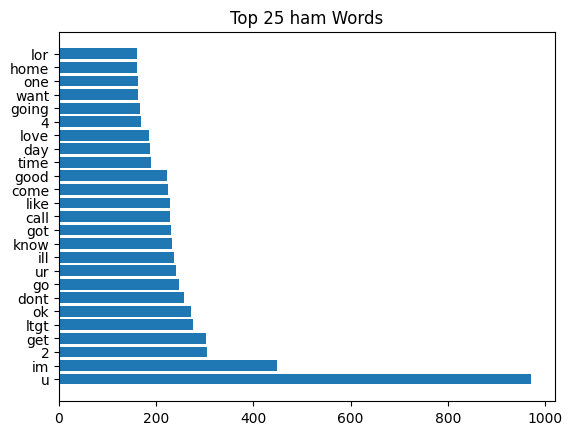

In [11]:
sort_ham_word=calculate_word_freq(ham_text,clean_text)
top_N=25
plt.barh(sort_ham_word['Word'][:top_N], sort_ham_word['Frequency'][:top_N])
plt.title(f"Top {top_N} ham Words")

## Build classification model to predict spam or ham

In [12]:
# convert the label from category to int, so that it can be evaluated.
df["label"] = np.where(df["label"] == "ham", 0, 1)
df["clean_text"] = df["text"].apply(lambda x: clean_text(x))

### split the data into train and test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"], df["label"], test_size=0.2, random_state=42
)
print(f" X_train shape: {X_train.shape}", f" X_test shape: {X_test.shape}")

 X_train shape: (4457,)  X_test shape: (1115,)


### build model based on word2vec and evaluate its performance

Fitting word2vec model...
Evaluating model...
Precision: 1.0 / Recall: 0.6 / Accuracy: 0.946


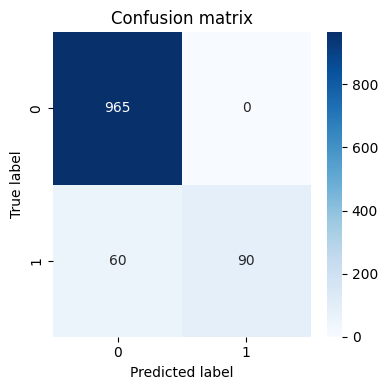

In [14]:
model = build_w2v_model()
print("Fitting word2vec model...")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Evaluating model...")
evaluate_model(y_test, y_pred)

cm=confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

### build model based on doc2vec and evaluate its performance

Fitting doc2vec model...
Evaluating model...
Precision: 0.981 / Recall: 0.68 / Accuracy: 0.955


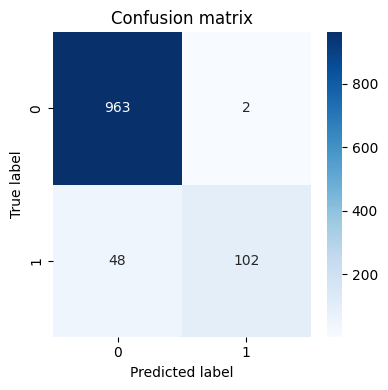

In [15]:
model = build_d2v_model()
print("Fitting doc2vec model...")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Evaluating model...")
evaluate_model(y_test, y_pred)

cm=confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

### build model based on sklearn TFIDF and evaluate its performance

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42
)

Evaluating model...
Precision: 1.0 / Recall: 0.793 / Accuracy: 0.972


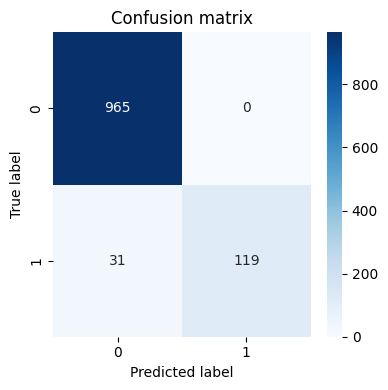

In [17]:
model = build_model()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Evaluating model...")
evaluate_model(y_test, y_pred)

cm=confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

In [18]:
# save the model into a pickle file
import pickle
pickle.dump(model, open("model/model.pkl", "wb"))
